## Feature Selection (uniprot_acc)
Basic feature selection methods implemented in scikit-learn.

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn import preprocessing
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.feature_selection import f_classif, chi2, f_regression
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
import pandas as pd
import urllib.request as urllib
import sys
import warnings
warnings.filterwarnings('ignore')
from numpy import array
from ipywidgets import widgets
#Import pandas_profiling
#from pandas_profiling import ProfileReport

In [43]:
import pandas as pd
df = pd.read_json('prueba_v7_1_json_for_pandas.json')


In [44]:
df = df[df['FILTER_2']==1]
#df_1['INTERNALLY_IDENTIFIED'] = df_1['INTERNALLY_IDENTIFIED'].fillna('False')
df = df[df['ref'] != '']
df = df[df['ref'].notnull()]
df = df.drop(columns=['MutationTaster_AAE','MutPred_Top5features',
                      'MutPred_AAchange','SiPhy_29way_pi', 'CANONICAL',
                      'CADD_phred_hg19','CADD_raw_hg19', 'CADD_raw_rankscore_hg19',
                      'Mastermind_MMID3', 'genename', 'Ensembl_geneid',
                      'clinvar_hgvs', 'ENSP','Feature', 'SEQQ',
                      'Mastermind_counts', 'HGVSc', 'HGVSp','Ensembl_proteinid',
                      'Ensembl_transcriptid', 'Codons', 'Existing_variation', 'MANE_SELECT',
                      'gnomAD_NFE_AF','HGVSc_ANNOVAR','HGVSc_VEP', 'HGVSc_snpEff',
                      'HGVSp_ANNOVAR', 'HGVSp_VEP', 'HGVSp_snpEff','hg19_chr', 'rs_dbSNP"','MEAN_VAF','STDEV_VAF','MAX_VAF','FRACTION_SAMPLES','NUM_SAMPLES_WITH_MUTATION','NUM_SAMPLES_WITH_VAF_LIKE_GERMINAL', 'GERMQ', 'STRAND', 'STRANDQ', 'DP', 'MMQ', 'MBQ', 'MFRL', 'ECNT', 'TLOD'])

df['INTERNALLY_IDENTIFIED'] = df['INTERNALLY_IDENTIFIED'].fillna(0)

df.loc[df['INTERNALLY_IDENTIFIED'] != 0, 'INTERNALLY_IDENTIFIED'] = 1
df.loc[df['COSMIC_N_MATCH'] != 0, 'COSMIC_N_MATCH'] = 1
df.loc[df['PREVIOUSLY_IDENTIFIED'] == True , 'PREVIOUSLY_IDENTIFIED'] = 1
df.loc[df['PREVIOUSLY_IDENTIFIED'] == False , 'PREVIOUSLY_IDENTIFIED'] = 0
df['DRIVER'] = df['INTERNALLY_IDENTIFIED'] + df['PREVIOUSLY_IDENTIFIED']
df.loc[df['DRIVER'] == 2 , 'DRIVER'] = 1
df.loc[df['ARTIFACTS'] == True , 'ARTIFACTS'] = 1
df.loc[df['ARTIFACTS'] == False , 'ARTIFACTS'] = 0

df = df.set_index('variantInternalId')
#df.STDEV_VAF = df['STDEV_VAF'].replace('NA', '0')
df.COSMIC_MATCH = df['COSMIC_MATCH'].replace('', 0)

columns_names = list(df.columns.values)
exceptions = []
for key in columns_names:
    try:
        df[key] = df[key].str.replace(",",".")
        
    except:
        exceptions.append(key)
    try:
        df[key] = df[key].map(lambda x: x.split('&')[0],  na_action = 'ignore')
    except:
        pass


df = df.replace('.', None)
df = df.replace(',', None)
df = df.replace('-', None)
df = df.replace('', None)
df_1 = df[df['ARTIFACTS']==1]
df_2 = df[df['DRIVER']==1]
df = pd.concat([df_2, df_1])

df.drop(columns=['INTERNALLY_IDENTIFIED'])
df.drop(columns=['PREVIOUSLY_IDENTIFIED'])
df.drop(columns=['ARTIFACTS'])

df.drop(columns=['LONGITUDINAL_BOTH'])
df.drop(columns=['LONGITUDINAL_ONLY_VISIT_1'])
df.drop(columns=['LONGITUDINAL_ONLY_VISIT_2'])


,SIFT_DESC,SIFT_SCORE,POLYPHEN_DESC,POLYPHEN_SCORE,ARTIFACTS,INTERNALLY_IDENTIFIED,WHITELIST,PREVIOUSLY_IDENTIFIED,COSMIC_MATCH,COSMIC_N_MATCH,...,phyloP30way_mammalian_rankscore,ref,refcodon,FILTER_1,FILTER_2,RPA,RU,STR,STRQ,DRIVER
variantInternalId,,,,,,,,,,,,,,,,,,,,,
chr1_1815788_C_A,deleterious,0,probably_damaging,1,0,1,False,1,NaN,0,...,0.15429,C,AAG,1,1,NaN,NaN,NaN,NaN,1
chr1_1815790_T_C,deleterious,0,probably_damaging,1,0,1,True,1,NaN,0,...,0.51903,T,AAG,1,1,NaN,NaN,NaN,NaN,1
chr1_43352635_T_G,deleterious,0.02,probably_damaging,0.999,0,1,False,1,NaN,0,...,0.51453,T,TAC,1,1,NaN,NaN,NaN,NaN,1
chr1_43352638_C_T,None,None,None,None,1,0,False,1,NaN,0,...,0.10452,C,CGA,1,1,NaN,NaN,NaN,NaN,1
chr1_43352639_G_A,deleterious,0.05,benign,0.003,0,0,False,1,NaN,0,...,0.09217,G,CGA,1,1,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrX_155077218_C_T,deleterious,0.02,benign,0.296,1,0,False,0,NaN,0,...,0.39869,C,CGT,1,1,NaN,NaN,NaN,NaN,0
chrX_155077225_A_G,deleterious,0,benign,0.031,1,0,False,0,NaN,0,...,0.88494,A,GAT,1,1,NaN,NaN,NaN,NaN,0
chrX_155078665_A_T,deleterious,0,probably_damaging,1,1,0,False,0,NaN,0,...,0.94714,A,CAT,1,1,NaN,NaN,NaN,NaN,0


In [46]:
df['DRIVER'].sum()

413

# Filtrado de Features y analisis de los datos 

En html adjunto

In [19]:
"""pandas_profiling_report  = df.profile_report(
    title="Pandas Profiling Report", 
    explorative=True,  #More analysis (Unicode)
    html={'style': 
          {'full_width': True,
           'theme':'flatly'} #available theme options: ‘bootswatch’ ,'flatly','united'
        }, 
    interactions = {'targets' : ['DRIVER']} , #When a list of variable names is given, only interactions between these and all other variables are given.
    progress_bar=True)
pandas_profiling_report.to_file("pandas_profiling_report.html")"""

'pandas_profiling_report  = df.profile_report(\n    title="Pandas Profiling Report", \n    explorative=True,  #More analysis (Unicode)\n    html={\'style\': \n          {\'full_width\': True,\n           \'theme\':\'flatly\'} #available theme options: ‘bootswatch’ ,\'flatly\',\'united\'\n        }, \n    interactions = {\'targets\' : [\'DRIVER\']} , #When a list of variable names is given, only interactions between these and all other variables are given.\n    progress_bar=True)\npandas_profiling_report.to_file("pandas_profiling_report.html")'

In [ ]:
# Identificamos los missing values visualmente
sns.heatmap(df.isnull(), cbar=False)

In [20]:
sumNA = list(df.isnull().sum(axis=0))
sumNA_filtered = []
for NAsum in sumNA:
    sumNA_filtered.append(NAsum < (70*df.shape[0]/100))
df_filtered = df.loc[:, sumNA_filtered]
filtered_columns = list(df.loc[:, ~np.array(sumNA_filtered)].columns.values)
no_filtered_columns = list(df.loc[:, np.array(sumNA_filtered)].columns.values)

In [21]:
string_columns = []
numeric_columns = []

for key in no_filtered_columns:
    try:
        df_filtered[key].dropna(axis=0).astype(float)           
        numeric_columns.append(key)
    except:
        string_columns.append(key)
        df_filtered[key] = df_filtered[key].fillna('NA')


In [22]:
knn_imputer = KNNImputer(n_neighbors = 5)
df_filtered_imputed_numeric = knn_imputer.fit_transform(df_filtered[numeric_columns])
df_filtered_imputed_numeric = pd.DataFrame(df_filtered_imputed_numeric)
df_filtered_imputed_numeric.columns = numeric_columns


In [23]:
len(numeric_columns)

132

In [28]:
#Filtrado de irrelevantes
from sklearn.feature_selection import VarianceThreshold

def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

# min_variance = .9 * (1 - .9) 
min_variance = 0.01
low_variance = variance_threshold_selector(df_filtered_imputed_numeric, min_variance) 

df_filtered_imputed_numeric_variance = low_variance
numeric_columns = list(df_filtered_imputed_numeric_variance.columns.values)

df_3 = np.concatenate([np.array(df_filtered[string_columns]), df_filtered_imputed_numeric_variance], axis=1)
df_3 = pd.DataFrame(df_3)
df_3.columns = list(string_columns) + list(numeric_columns)
#Filtrado de variables no usadas en modelos
df_4 = df_3.drop(columns=['VARIANT_CLASS', 'SYMBOL_SOURCE', 'GENCODE_basic', 'Feature_type', 'BIOTYPE'])
df_4 = df_4.drop(columns=['INTERNALLY_IDENTIFIED', 'PREVIOUSLY_IDENTIFIED', 'ARTIFACTS', 'LONGITUDINAL_BOTH', 'LONGITUDINAL_ONLY_VISIT_1', 'LONGITUDINAL_ONLY_VISIT_2', 'WHITELIST'])

In [29]:
"""pandas_profiling_report  = df_4.profile_report(
    title="Pandas Profiling Report", 
    explorative=True,  #More analysis (Unicode)
    html={'style': 
          {'full_width': True,
           'theme':'flatly'} #available theme options: ‘bootswatch’ ,'flatly','united'
        }, 
    interactions = {'targets' : ['DRIVER']} , #When a list of variable names is given, only interactions between these and all other variables are given.
    progress_bar=True)
pandas_profiling_report.to_file("pandas_profiling_report_filtered_imputed.html")"""

'pandas_profiling_report  = df_4.profile_report(\n    title="Pandas Profiling Report", \n    explorative=True,  #More analysis (Unicode)\n    html={\'style\': \n          {\'full_width\': True,\n           \'theme\':\'flatly\'} #available theme options: ‘bootswatch’ ,\'flatly\',\'united\'\n        }, \n    interactions = {\'targets\' : [\'DRIVER\']} , #When a list of variable names is given, only interactions between these and all other variables are given.\n    progress_bar=True)\npandas_profiling_report.to_file("pandas_profiling_report_filtered_imputed.html")'

In [30]:
#df_filtered_imputed_numeric = df_filtered_imputed_numeric.drop(columns=['INTERNALLY_IDENTIFIED', 'PREVIOUSLY_IDENTIFIED', 'ARTIFACTS', 'DRIVER', 'LONGITUDINAL_BOTH', 'LONGITUDINAL_ONLY_VISIT_1', 'LONGITUDINAL_ONLY_VISIT_2'])
df_filtered_imputed_numeric_variance = df_filtered_imputed_numeric_variance.drop(columns=['INTERNALLY_IDENTIFIED', 'PREVIOUSLY_IDENTIFIED', 'ARTIFACTS', 'LONGITUDINAL_BOTH', 'LONGITUDINAL_ONLY_VISIT_1', 'LONGITUDINAL_ONLY_VISIT_2', 'WHITELIST', 'DRIVER', 'Gene'])
#np.array(df_3['DRIVER'])


numeric_columns.remove('WHITELIST')
numeric_columns.remove('INTERNALLY_IDENTIFIED')
numeric_columns.remove('PREVIOUSLY_IDENTIFIED')
numeric_columns.remove('ARTIFACTS')
numeric_columns.remove('DRIVER')
numeric_columns.remove('LONGITUDINAL_BOTH')
numeric_columns.remove('LONGITUDINAL_ONLY_VISIT_1')
numeric_columns.remove('LONGITUDINAL_ONLY_VISIT_2')
numeric_columns.remove('Gene')

In [31]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
y = np.array(df_3['DRIVER']).astype(int)
X = np.array(df_4)
X_1 = pd.DataFrame(df_filtered_imputed_numeric_variance)
scaler = preprocessing.StandardScaler()
X_1 = pd.DataFrame(scaler.fit_transform(X_1))
numeric_columns = [item.replace('+', 'plus') for item in numeric_columns]
numeric_columns = [item.replace('-', '_') for item in numeric_columns]

X_1.columns = numeric_columns

dummies = pd.get_dummies(df_3['SYMBOL'], drop_first = True)
#all_columns = all_columns + '+' + '+'.join(list(dummies.columns.values.astype(str)))
#X_1= pd.concat([X_1, dummies], axis = 1)


In [32]:


#X_1 = np.array(X_1, dtype=float)
modelo = sm.Logit(endog=y, exog=X_1)
modelo2 = modelo.fit()
modelo2.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.269861
         Iterations 9


,coef,std err,z,P>|z|,[0.025,0.975]
SIFT_SCORE,0.2245,0.232,0.969,0.333,-0.230,0.679
POLYPHEN_SCORE,-0.3430,0.386,-0.890,0.374,-1.099,0.413
COSMIC_N_MATCH,0.2960,0.124,2.384,0.017,0.053,0.539
MPOS,-0.0202,0.101,-0.201,0.841,-0.218,0.177
POPAF,-0.4862,0.141,-3.460,0.001,-0.762,-0.211
cDNA_position,-1.1387,1.365,-0.834,0.404,-3.814,1.537
CDS_position,0.5480,2.39e+06,2.29e-07,1.000,-4.69e+06,4.69e+06
Protein_position,0.5480,2.39e+06,2.29e-07,1.000,-4.69e+06,4.69e+06
CADD_PHRED,0.1595,0.723,0.221,0.825,-1.258,1.577
CADD_RAW,-0.3293,0.765,-0.430,0.667,-1.829,1.171


In [33]:
f = open('LogitFeatureNoGene.csv', 'w')
try:
    f.write(modelo2.summary().tables[1].as_csv())
finally:
    f.close()

In [34]:
pva = modelo2.pvalues


pva = pd.DataFrame(pva)
pva.columns = ['pvalue']
pva

,pvalue
SIFT_SCORE,0.332633
POLYPHEN_SCORE,0.373706
COSMIC_N_MATCH,0.017128
MPOS,0.841070
POPAF,0.000540
...,...
phyloP100way_vertebrate_rankscore,0.981703
phyloP17way_primate,0.629352
phyloP17way_primate_rankscore,0.316587
phyloP30way_mammalian,0.329363


In [49]:
pvalues = pd.read_csv('LogitFeatureNoGene.csv')

pvalues.set_index(X_1.columns, inplace = True)

pvalues = pvalues.drop(pvalues.columns[0], axis= 1)

pvalues.columns = ['coef', 'stderr', 'z', 'pvalue', '0.025', '0.975']

pvalues['pvalue'] = pva['pvalue'].values
pvalues = pvalues.sort_values(by=['pvalue'])
pvalues = pvalues[pvalues['pvalue'].astype(float)< 0.05]
pvalues.to_csv()
f = open('LogitFeature.csv', 'w')
try:
    f.write(pvalues.to_csv())
finally:
    f.close()

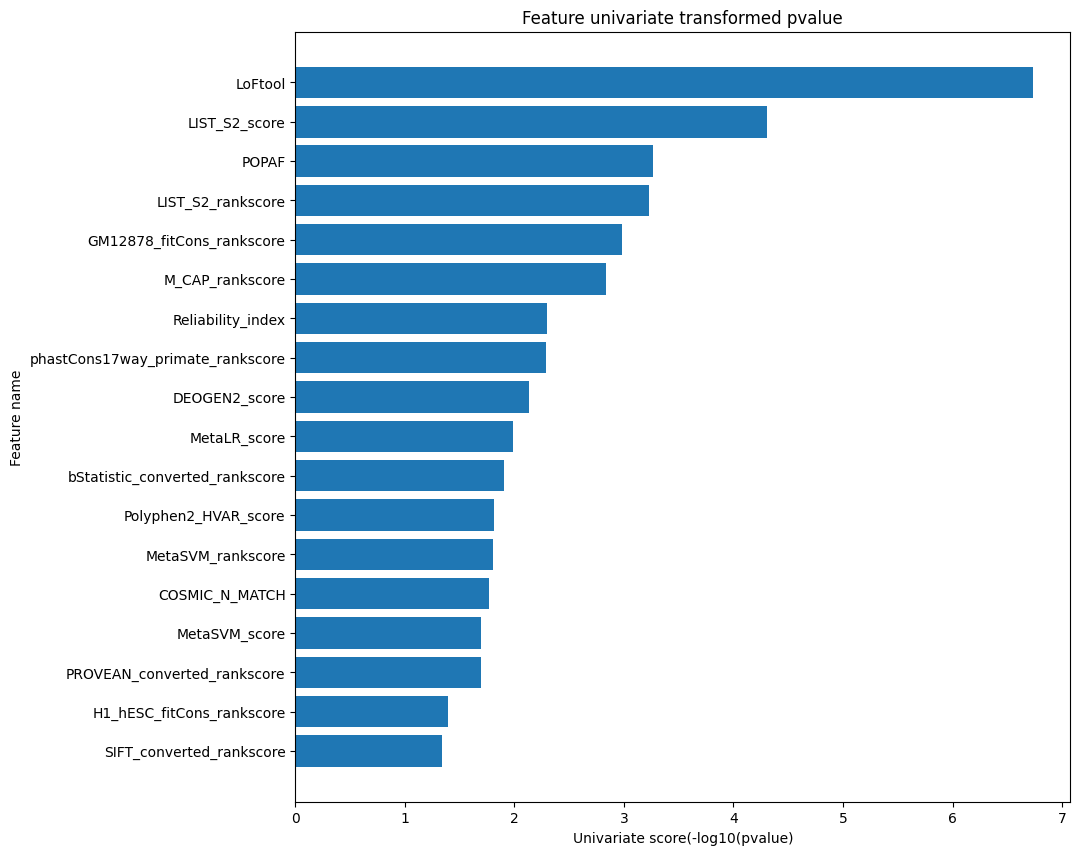

In [37]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))

ax.barh(list(pvalues.index.astype(str)), list(-np.log10(pvalues.pvalue.astype(float))))
ax.set_title("Feature univariate transformed pvalue")
ax.set_ylabel("Feature name")
ax.set_xlabel(r"Univariate score(-log10(pvalue)")
ax.invert_yaxis() 

plt.show()


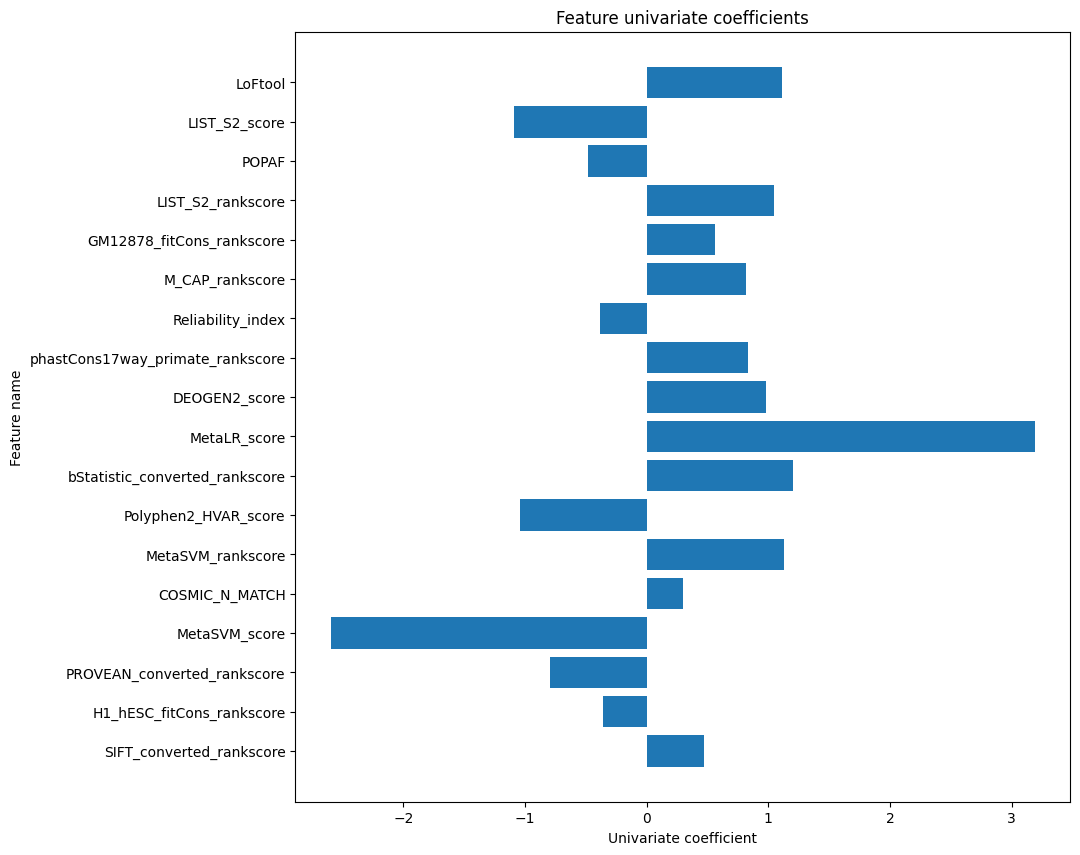

In [39]:

fig, ax = plt.subplots(figsize=(10,10))

ax.barh(list(pvalues.index.astype(str)), pvalues.coef.astype(float))
ax.set_title("Feature univariate coefficients")
ax.set_ylabel("Feature name")
ax.set_xlabel(r"Univariate coefficient")
ax.invert_yaxis() 

plt.show()

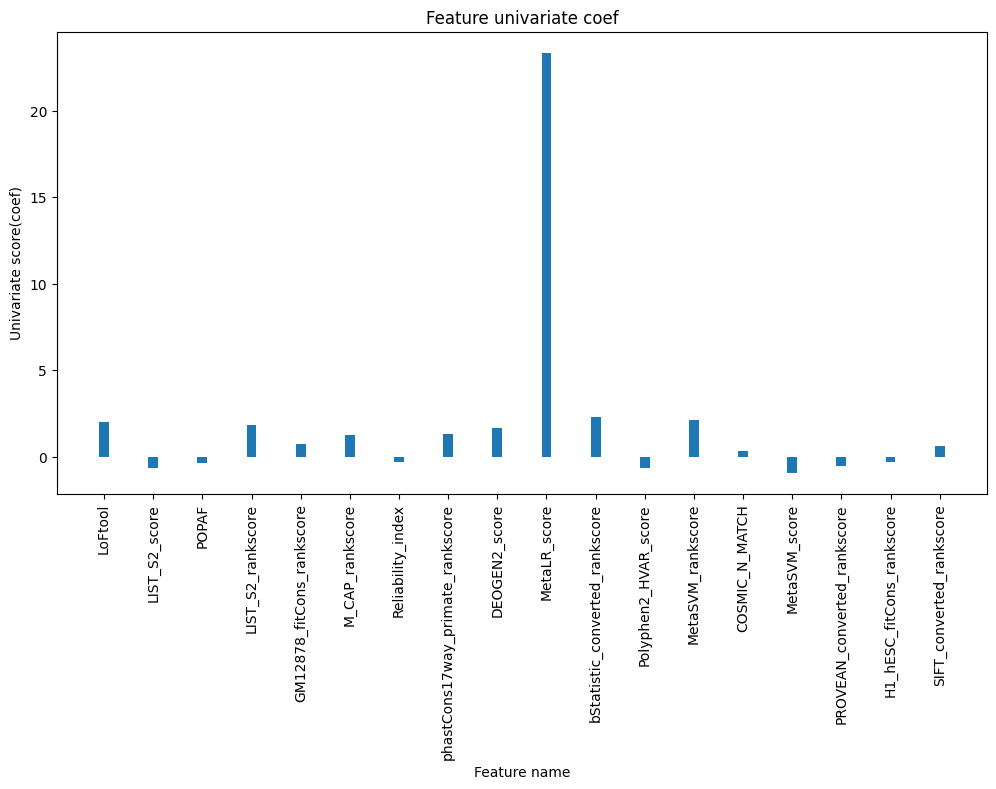

In [40]:
coef = []
for c in pvalues.coef.astype(float):
    if c > 0:
        coef.append(np.exp(c)-1)
    else:
        coef.append(-(1-np.exp(c)))
plt.figure(figsize=(12,6))
plt.bar(pvalues.index.astype(str), coef, width=0.2, linewidth=0.7)
plt.title("Feature univariate coef")
plt.xlabel("Feature name")
plt.ylabel(r"Univariate score(coef)")

plt.xticks(rotation=90)
plt.show()


In [41]:
print(len(list(pvalues.index)))
list(pvalues.index)

18


['LoFtool',
 'LIST_S2_score',
 'POPAF',
 'LIST_S2_rankscore',
 'GM12878_fitCons_rankscore',
 'M_CAP_rankscore',
 'Reliability_index',
 'phastCons17way_primate_rankscore',
 'DEOGEN2_score',
 'MetaLR_score',
 'bStatistic_converted_rankscore',
 'Polyphen2_HVAR_score',
 'MetaSVM_rankscore',
 'COSMIC_N_MATCH',
 'MetaSVM_score',
 'PROVEAN_converted_rankscore',
 'H1_hESC_fitCons_rankscore',
 'SIFT_converted_rankscore']

## Rendimiento de KNN usando todas las caracteristicas
Llevamos a cabo un proceso de validación cruzada de 10 veces 10-fold para estimar el rendimiento de predicción del clasificador KNN usando todas las caracteristicas. Estandarizamos los datos para que tengan medioa 0 y desviación 1. Posteriormente, elegimos los valores de los hiperparámetros que se espera que funcionen bien. Lo hacemos utilizando un paso de validación cruzada interna, utilizando 5-fold. Utilizamos K-Nearest-Neighbors como clasificador y elegimos el número de vecinos utilizado. Para terminar ajustamos el modelo final y estimamos su rendimiento.

In [ ]:
# This is the number of times the 10-fold cv process will be repeated
X_1 = X_1.drop(columns=['DRIVER'])
X = np.array(X_1)
n_repeats = 10
rkf = RepeatedKFold(n_splits=10, n_repeats = n_repeats, random_state=0)

#We create an array to store the results

knn_error = np.zeros(10 * n_repeats)

split = 0

for train_index, test_index in rkf.split(X, y):
    
    # We print a dot for each train / test partition
    
    sys.stdout.write('.')
    sys.stdout.flush()
    
    # First simple variable ranking
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # We standardize the data
    
    # Already done
    
    #Choosing good vales for the number of neighbors
    
    #We create a Pipeline for training the classifier in the inner cross validation procedure.
    
    pipeline = Pipeline([ ('knn', KNeighborsClassifier()) ])
    
    #We specify values for the hyperparameters of the classifier. In this case, the number of neighbors to consider.
    
    N_neighbors = [1, 3, 5, 7, 11, 15, 20, 25, 30]
    param_grid = { 'knn__n_neighbors': N_neighbors }
    
    #Evaluating the Performance for each Value of the Hyperparameters
    
    skfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=0)
    gridcv = GridSearchCV(pipeline, cv=skfold, n_jobs=1, param_grid=param_grid, \
        scoring=make_scorer(accuracy_score))
    result = gridcv.fit(X_train, y_train)
    
    #Obtaining the Results
    
    accuracies = gridcv.cv_results_['mean_test_score']
    std_accuracies = gridcv.cv_results_['std_test_score']
    
    #best parameter value
    
    best_knn = N_neighbors[np.argmax(accuracies)]
    
    #Fitting the Final Model and Estimating Its Performance
    
    knn = KNeighborsClassifier(n_neighbors = best_knn)
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    knn_error[split] = 1.0 - np.mean(knn.predict(X_test) == y_test)
    split += 1

In [ ]:
print("Mean Error KNN:%f" % np.mean(knn_error))
print("\tStd Mean Error KNN:%f" % (np.std(knn_error) / np.sqrt(len(knn_error))))

## Rendimiento de KNN con selección de características ANOVA

In [ ]:
# This is the number of times the 10-fold cv process will be repeated

n_repeats = 10
rkf = RepeatedKFold(n_splits=10, n_repeats = n_repeats, random_state=0)

#We create an array to store the results

knn_error_ANOVA = np.zeros(10 * n_repeats)

split = 0

for train_index, test_index in rkf.split(X, y):
    
    # We print a dot for each train / test partition
    
    sys.stdout.write('.')
    sys.stdout.flush()
    
    # First simple variable ranking
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # We standardize the data
    

    # We filter the data first using SelectKBest
    #Using as a scoring function f_classif
    
    filtering = SelectKBest(f_regression, k = 10)
    filtering.fit(X_train, y_train)
    
    X_train_A = filtering.transform(X_train)
    X_test_A = filtering.transform(X_test)
    
    #We create a Pipeline for training the classifier in the inner cross validation procedure.
    
    pipeline = Pipeline([ ('knn', KNeighborsClassifier()) ])
    
    #We specify values for the hyperparameters of the classifier. 
    #In this case, the number of neighbors to consider.
    
    N_neighbors = [1, 3, 5, 7, 11, 15, 20, 25, 30]
    param_grid = { 'knn__n_neighbors': N_neighbors }
    
    #Evaluating the Performance for each Value of the Hyperparameters using 5-fold cross validation
    
    skfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=0)
    gridcv = GridSearchCV(pipeline, cv=skfold, n_jobs=1, param_grid=param_grid, \
        scoring=make_scorer(accuracy_score))
    result = gridcv.fit(X_train_A, y_train)
    
    #Obtaining the Results
    
    accuracies = gridcv.cv_results_['mean_test_score']
    std_accuracies = gridcv.cv_results_['std_test_score']
    
    #best parameter value
    
    best_knn = N_neighbors[np.argmax(accuracies)]
    
    #Fitting the Final Model and Estimating Its Performance
    
    knn = KNeighborsClassifier(n_neighbors = best_knn)
    knn.fit(X_train_A, y_train)
    
    y_pred = knn.predict(X_test_A)
    knn_error_ANOVA[split] = 1.0 - np.mean(knn.predict(X_test_A) == y_test)
    split += 1

In [ ]:
print("Mean Error KNN:%f" % np.mean(knn_error_ANOVA))
print("\tStd Mean Error KNN:%f" % (np.std(knn_error_ANOVA) / np.sqrt(len(knn_error_ANOVA))))

## Rendimiento de KNN usando Random Forest

In [ ]:
# This is the number of times the 10-fold cv process will be repeated

n_repeats = 10
rkf = RepeatedKFold(n_splits=10, n_repeats = n_repeats, random_state=0)

#We create an array to store the results

knn_error_RF = np.zeros(10 * n_repeats)

split = 0

for train_index, test_index in rkf.split(X, y):
    # We print a dot for each train / test partition
    
    sys.stdout.write('.')
    sys.stdout.flush()
    
    # First simple variable ranking
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # We standardize the data
    

    
    # We first filter the data first using SelectKBest
    #Using as a scoring function f_classif
    # we keep only the 20% most promising features
    
    filtering = SelectKBest(f_regression, k = int(np.round(X.shape[ 1 ] * 0.2)))
    filtering.fit(X_train, y_train)
    
    X_train_rf = filtering.transform(X_train)
    X_test_rf = filtering.transform(X_test)
    
    # we filter the data again using rf for feature selection
    
    rf_selection =  SelectFromModel(RandomForestClassifier(n_estimators = 2000, \
    random_state = 0), threshold = 0.0)
    rf_selection.fit(X_train_rf, y_train)
    rf_selection.threshold = -1.0 * np.sort(-1.0 * rf_selection.estimator_.feature_importances_)[ 9 ]
    
    X_train_rf = rf_selection.transform(X_train_rf)
    X_test_rf = rf_selection.transform(X_test_rf)
    
    #We Choose the best value for the number of neighbors in each cross validation partition with 5 fold cv
    
    pipeline = Pipeline([ ('knn', KNeighborsClassifier()) ])
    
    N_neighbors = [1, 3, 5, 7, 11, 15, 20, 25, 30]
    param_grid = { 'knn__n_neighbors': N_neighbors }
    
    skfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=0)
    gridcv = GridSearchCV(pipeline, cv=skfold, n_jobs=1, param_grid=param_grid, \
        scoring=make_scorer(accuracy_score))
    result = gridcv.fit(X_train_rf, y_train)

    accuracies = gridcv.cv_results_['mean_test_score']
    std_accuracies = gridcv.cv_results_['std_test_score']
    
    #best parameter value
    
    best_knn = N_neighbors[np.argmax(accuracies)]
    
    # We fit the classifiers and compute the test performance
    
    knn = KNeighborsClassifier(n_neighbors = best_knn)
    knn.fit(X_train_rf, y_train)    

    knn_error_RF[ split ] = 1.0 - np.mean(knn.predict(X_test_rf) == y_test)
    
    split += 1


In [ ]:
print("Mean Error KNN:%f" % np.mean(knn_error_RF))
print("\tStd Mean Error KNN:%f" % (np.std(knn_error_RF) / np.sqrt(len(knn_error_RF))))

## Performance of the NKK  as a function of the features used for prediction

In [ ]:
# This is the number of times the 10-fold cv process will be repeated

n_repeats = 10
rkf = RepeatedKFold(n_splits=10, n_repeats = n_repeats, random_state=0)

#We set n_features to contain the number of features teste
n_features = np.unique(np.round(np.exp(np.arange(0, np.log(120), 0.1))).astype(np.int))

#We create an array to store the results

knn_error_ANOVA = np.zeros((10 * n_repeats, len(n_features)))
knn_error_random = np.zeros((10 * n_repeats, len(n_features)))

split = 0

for train_index, test_index in rkf.split(X, y):

    # We print a dot for each train / test partition
    
    sys.stdout.write('.')
    sys.stdout.flush()

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # We standardize the data
    

    # This random array will be used to pick up features at random as a base-line
    # to compare with.
    
    random_features = np.random.permutation(X.shape[ 1 ])

    # For we loop over the number of features to be tested 
    
    for i in range(len(n_features)):
        
        # We create a filter to select the required number of features
        # The filter will be based on the F-statistc "f_classif".

        filtering = SelectKBest(f_regression, k = n_features[ len(n_features) - i - 1 ])
        filtering.fit(X_train, y_train)
        
        # We carry out the feature selection process
        
        X_train_sel = filtering.transform(X_train)
        X_test_sel = filtering.transform(X_test)

        # We fit the classifier on the training data and evaluate its performance on
        # test data. We use k=3

        knn = KNeighborsClassifier(n_neighbors = 3)
        knn.fit(X_train_sel, y_train)
        
        knn_error_ANOVA[ split, len(n_features) - i - 1 ] = 1.0 - np.mean(knn.predict(X_test_sel) == y_test)

        knn.fit(X_train[ :, random_features[ 0 : n_features[ len(n_features) - i - 1 ] ] ], y_train)

        knn_error_random[ split, len(n_features) - i - 1 ] = 1.0 - \
            np.mean(knn.predict(X_test[ :, random_features[ 0 : \
            n_features[ len(n_features) - i - 1 ] ] ]) == y_test)
        
        
    split += 1

In [ ]:
# We compute mean errors and the corresponding standard deviations

error = np.mean(knn_error_ANOVA, 0)
error_std = np.std(knn_error_ANOVA, 0) / np.sqrt(knn_error_ANOVA.shape[ 0 ])

error_random = np.mean(knn_error_random, 0)
error_random_std = np.std(knn_error_random, 0) / np.sqrt(knn_error_random.shape[ 0 ])

In [ ]:
# The axis legend will consdier a subset of the features tested

sel = np.arange(1, len(n_features) + 1, 8) - 1

plt.figure(figsize=(17,12))
line1, = plt.plot(n_features, error, 's-', color="b")
line2, = plt.plot(n_features, error_random, 's-', color="r")
plt.fill_between(n_features, error - error_std, error + error_std, alpha=0.1, color="b")
plt.fill_between(n_features, error_random - error_random_std, \
    error_random + error_random_std, alpha=0.1, color="r")
plt.grid()
plt.title("KNN: Performance in terms of the number of features")
plt.xlabel('Number of Features')
plt.xticks(np.array([1, 3, 5, 7, 10, 15, 20, 30, 50, 100, 200]))
plt.ylabel('SRBCT - Classification Error')
plt.ylim(0.0,  0.5)
legend_handles = [ mlines.Line2D([], [], color='b', marker='s', \
    markersize=15, label='Variable Ranking using F-statistic'),
    mlines.Line2D([], [], color='r', marker='s', \
    markersize=15, label='Picking Features at Random') ]
plt.legend(handles=legend_handles, loc = 1)
plt.show()

## The feature selection is done externally to the cross-validation loop using all the available data

In [ ]:
n_repeats = 10
rkf = RepeatedKFold(n_splits=10, n_repeats = n_repeats, random_state=0)

#We set n_features to contain the number of features teste
n_features = np.unique(np.round(np.exp(np.arange(0, np.log(120), 0.1))).astype(np.int))

#We create an array to store the results

knn_error_ANOVA1 = np.zeros((10 * n_repeats, len(n_features)))

split = 0

for i in range(len(n_features)):
        
    # We create a filter to select the required number of features
    # The filter will be based on the F-statistc "f_classif".

    #filtering = SelectKBest(f_regression, k = n_features[ len(n_features) - i - 1 ])
    #filtering.fit(X, y)
    
    #X_sel = filtering.transform(X)
    X_sel = X_1.loc[: ,list(pvalues.index)[-i]] 

for train_index, test_index in rkf.split(X_sel, y):

    # We print a dot for each train / test partition
    
    sys.stdout.write('.')
    sys.stdout.flush()

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # We standardize the data
    


    # We fit the classifier on the training data and evaluate its performance on
    # test data. We use k=3
        
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train, y_train)
        
    knn_error_ANOVA1[ split, len(n_features) - i - 1 ] = 1.0 - np.mean(knn.predict(X_test) == y_test)
  
    split += 1

In [ ]:
# We compute mean errors and the corresponding standard deviations

error1 = np.mean(knn_error_ANOVA1, 0)
error1_std = np.std(knn_error_ANOVA1, 0) / np.sqrt(knn_error_ANOVA1.shape[ 0 ])


In [ ]:
# The axis legend will consdier a subset of the features tested

sel = np.arange(1, len(n_features) + 1, 8) - 1

plt.figure(figsize=(18,15))
line1, = plt.plot(n_features, error, 's-', color="b")
line2, = plt.plot(n_features, error_random, 's-', color="r")
line3, = plt.plot(n_features, error1, 's-', color="g")
plt.fill_between(n_features, error - error_std, error + error_std, alpha=0.1, color="b")
plt.fill_between(n_features, error_random - error_random_std, \
    error_random + error_random_std, alpha=0.1, color="r")
plt.fill_between(n_features, error1 - error1_std, error1 + error1_std, alpha=0.1, color="g")
plt.grid()
plt.title("KNN: Performance in terms of the number of features")
plt.xlabel('Number of Features')
plt.xticks(np.array([1, 3, 5, 7, 10, 15, 20, 30, 50, 100, 200]))
plt.ylabel('SRBCT - Classification Error')
plt.ylim(0,  0.5)
legend_handles = [ mlines.Line2D([], [], color='b', marker='s', \
    markersize=15, label='Variable Ranking using LR-Pvalues'),
    mlines.Line2D([], [], color='r', marker='s', \
    markersize=15, label='Picking Features at Random'), 
    mlines.Line2D([], [], color='g', marker='s', \
    markersize=15, label='Variable Ranking out og CV using LR pvalues')]
plt.legend(handles=legend_handles, loc = 1)
plt.show()

In [ ]:
print('El menor error se consigue con el numero de caracteristicas: %f' % n_features[np.argmin(error)])

##  particular features should be used for prediction on this dataset.

In [ ]:
important_features = {}
scores = {}
pvalues1 = {}
n_repeats = 10
rkf = RepeatedKFold(n_splits=10, n_repeats = n_repeats, random_state=0)
features = X_1.columns.values
#We set n_features to contain the number of features teste
n_features = np.unique(np.round(np.exp(np.arange(0, np.log(126), 0.1))).astype(np.int))

#We create an array to store the results

knn_error_ANOVA = np.zeros((10 * n_repeats, len(n_features)))
knn_error_random = np.zeros((10 * n_repeats, len(n_features)))

split = 0

for train_index, test_index in rkf.split(X_1, y):

    # We print a dot for each train / test partition
    
    sys.stdout.write('.')
    sys.stdout.flush()

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train = pd.DataFrame(X_train)
    X_train.columns = X_1.columns.values
    X_test = pd.DataFrame(X_train)
    X_test.columns = X_1.columns.values
    
    # We standardize the data
    

    
    # This random array will be used to pick up features at random as a base-line
    # to compare with.
    
    random_features = np.random.permutation(X.shape[ 1 ])

    # For we loop over the number of features to be tested 
    
    for i in range(len(n_features)):
        
        # We create a filter to select the required number of features
        # The filter will be based on the F-statistc "f_classif".


        # We carry out the feature selection process
        
        X_train_sel = X_train.loc[:, list(pvalues.index)[-i]] 
        X_test_sel = X_test.loc[:, list(pvalues.index)[-i]] 
        

        #we keep the position of the best features
        features = np.array(features)
        filter = filtering.get_support(indices=True)
        
        #we build a dictionary that contains the best features as a function of the n_feature used
        important_features[n_features[-(i+1)]]=features[filter]
        scores[n_features[-(i+1)]] = -np.log10(filtering.pvalues_[filter])
        pvalues1[n_features[-(i+1)]] = filtering.pvalues_[filter]

In [ ]:
pvalues.index[:int(n_features[np.argmin(error)])]

In [ ]:
important_features[int(n_features[np.argmin(error)])]

En particular, dado que en este conjunto de datos el menor error de prediccion se consigue utlizando 110 caracteristicas (puede observarse en el grafico anterior), tendriamos que las mejores caracteristicas serían: 

In [ ]:
scores[int(n_features[np.argmin(error)])]

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.bar(pvalues.index[:int(n_features[np.argmin(error)])], -np.log10(pvalues.pvalue[:int(n_features[np.argmin(error)])]), width=0.2, linewidth=0.7)
plt.title("Feature univariate score")
plt.xlabel("Feature name")
plt.ylabel(r"Univariate score(p_{value})$)")

plt.xticks(rotation=90)
plt.show()



In [ ]:
plt.figure(figsize=(12,6))
plt.bar(important_features[int(n_features[np.argmin(error)])], pvalues1[int(n_features[np.argmin(error)])], width=0.2, linewidth=0.7)
plt.title("Feature univariate score")
plt.xlabel("Feature name")
plt.ylabel(r"Univariate score(p_{value})$)")

plt.xticks(rotation=90)
plt.show()

In [ ]:
pvalues[int(n_features[np.argmin(error)])]

['cDNA_position' 'CDS_position' 'Protein_position' 'LoFtool'
 'BayesDel_addAF_rankscore' 'BayesDel_addAF_score'
 'BayesDel_noAF_rankscore' 'BayesDel_noAF_score' 'CADD_phred' 'CADD_raw'
 'CADD_raw_rankscore' 'ClinPred_rankscore' 'DANN_rankscore'
 'DEOGEN2_rankscore' 'DEOGEN2_score' 'Eigen_phred_coding'
 'Eigen_raw_coding' 'Eigen_raw_coding_rankscore' 'LIST_S2_rankscore'
 'LIST_S2_score' 'MVP_rankscore' 'MetaRNN_rankscore' 'MetaRNN_score'
 'MutationTaster_converted_rankscore' 'REVEL_rankscore' 'REVEL_score'
 'VEST4_rankscore' 'VEST4_score' 'bStatistic'
 'bStatistic_converted_rankscore'] 30


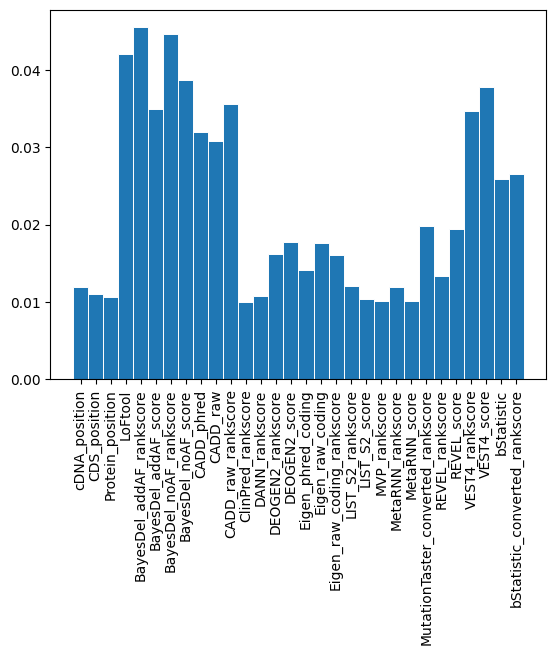

In [29]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

LR = RandomForestClassifier()
Fselection = SelectFromModel(estimator = LR)
Fselection.fit(X_1, y)
print(Fselection.get_feature_names_out(input_features=features),
      len(Fselection.get_feature_names_out(input_features=features)))

fig, ax = plt.subplots()
fe = np.array(features)

coef = np.array(Fselection.estimator_.feature_importances_)
ax.bar(fe[Fselection.get_support()], coef[Fselection.get_support()], width=1, edgecolor="white", linewidth=0.7)
plt.xticks(rotation=90)
plt.show()
